# Fit Zinser data, including relative increase in pop size

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafile = 'data/Zinser_SizeDist_regrid-30-15.nc'

data_gridded = {}
with nc4.Dataset(datafile) as nc:
    for var in nc.variables:
        data_gridded[var] = nc.variables[var][:]
        
data_gridded['PAR'] *= 200.0/22.0 # make light similar for this experiment (it is later normalized by E_star) 

In [2]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

data_gridded['obspopsum'] = a_norm.values

data_fig2a

,exper time,cells A,cells B,FALS,time of day
0,0,6.346000e+07,6.503348e+07,0.1838,8
1,2,6.821390e+07,6.512750e+07,0.2147,10
2,4,6.871540e+07,6.523250e+07,0.2640,12
3,6,6.129510e+07,6.298554e+07,0.3314,14
4,8,6.547930e+07,6.597570e+07,0.3950,16
5,10,6.468750e+07,6.559250e+07,0.4416,18
6,12,7.017000e+07,7.009750e+07,0.4033,20
7,14,7.907500e+07,8.327500e+07,0.3108,22
8,16,8.929500e+07,9.382750e+07,0.2448,0
9,18,1.049125e+08,1.045200e+08,0.2020,2


In [3]:
v_min = data_gridded['v_min']
delta_v = 1.0/data_gridded['delta_v_inv']
v = v_min * 2**(np.arange(data_gridded['m'])*delta_v) 

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

fig,axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))

ax = axs[0]
ax.plot(data_gridded['time'], data_gridded['PAR'], color='gold')
ax.set(ylabel='PAR')
for iday in range(2):
    ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
    
ax = axs[1]
pc = ax.pcolormesh(data_gridded['time'],v,data_gridded['w_obs'])
ax.set(ylabel='size ($\mu$m$^3$)', xlabel='time (minutes)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [5]:
# prepare data for Stan model

dt = 20 # in units of minutes

data = {'dt':dt}
for k in ('m','v_min','delta_v_inv','obspopsum'):
    data[k] = data_gridded[k]

data['obs'] = data_gridded['w_obs']
data['t_obs'] = data_gridded['time']
data['E'] = data_gridded['PAR']
# use first measurements as initial conditions
data['w_ini'] = data_gridded['w_obs'][:,0]

# limit the data

limit_days = 2
stride_t_obs = 1 # keep everything

if limit_days > 0:
    limit_minutes = limit_days*1440
    
    ind_obs = data['t_obs'] < limit_minutes
    data['t_obs'] = data['t_obs'][ind_obs]
    data['obspopsum'] = data['obspopsum'][ind_obs]
    data['obs'] = data['obs'][:,ind_obs]

    data['nt'] = int(limit_minutes//data['dt'])
    
if stride_t_obs > 0:
    data['t_obs'] = data['t_obs'][::stride_t_obs]
    data['obs'] = data['obs'][:,::stride_t_obs]

data['nt_obs'] = data['obs'].shape[1]
    
# finally, add light data
t = np.arange(data['nt'])*data['dt']
data['E'] = np.interp(t, xp=data_gridded['time'], fp=data_gridded['PAR'])
'''
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(data_gridded['time'], data_gridded['PAR'], color='gold')
ax.plot(t, data['E'], color='orange', ls=':')
ax.set(ylabel='PAR')
for iday in range(2):
    ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
'''
None

### load various models and modify prior for some of them

In [6]:
import re

stan_files = {
    'onedelta_lightthresh':'stancode/matrixmodel_onedelta-lightthresh_normparam_trackgrowth_popsum.stan',
    'freedelta_lightthresh':'stancode/matrixmodel_freedelta-lightthresh_normparam_trackgrowth_popsum.stan',
    'resp_lightthresh':'stancode/matrixmodel_freedelta-lightthresh_resp_normparam_trackgrowth_popsum.stan',
    #'freedelta':'stancode/matrixmodel_freedelta_normparam_trackgrowth_popsum.stan',
    #'resp':'stancode/matrixmodel_freedelta_resp_normparam_trackgrowth_popsum.stan',
    #'resp_gammai':'stancode/matrixmodel_freedelta_resp_gammai_normparam_trackgrowth_popsum.stan',
    #'respi_gammai':'stancode/matrixmodel_freedelta_respi_gammai_normparam_trackgrowth_popsum.stan',
    #'gammai':'stancode/matrixmodel_freedelta_gammai_normparam_trackgrowth_popsum.stan',
}
desc = {
    'onedelta_lightthresh':'model with one delta (no size-dep), light threshold for division',
    'freedelta_lightthresh':'model with "free" deltas, light threshold for division',
    'resp_lightthresh':'model with respiration, "free" deltas, light threshold for division',
    'freedelta':'basic model with "free" deltas',
    'resp':'model with respiration and "free" deltas',
    'resp_gammai':'model with respiration, size-dep. growth and "free" deltas',
    'respi_gammai':'model with size-dep. respiration, size-dep. growth and "free" deltas',
    'gammai':'model with size-dep. growth and "free" deltas',
}

stan_codes = {}
for name in stan_files:
    with open(stan_files[name]) as f:
        stan_codes[name] = f.read()
'''
for name in ('respi_gammai',):
    name_new = name+'_enforceresp'
    code_split = stan_codes[name].split('\n')
    code_split_new = []
    for line in code_split:
        m = re.match('^( *respiration *\~)',line)
        if m:
            code_split_new.append(m.groups(0)[0]+' uniform(0.1,10.0); // enforce respiration')
        else:
            code_split_new.append(line)
    stan_codes[name_new] = '\n'.join(code_split_new)
    desc[name_new] = desc[name] + ' with enforced respiration'
    
for name in ('respi_gammai','gammai'):
    name_new = name+'_enforcediv'
    code_split = stan_codes[name].split('\n')
    code_split_new = []
    for line in code_split:
        m = re.match('^( *real)<lower=0>  *delta_mu',line)
        if m:
            code_split_new.append(m.groups(0)[0]+'<lower=0.5> delta_mu; // enforce division')
        else:
            code_split_new.append(line)
    stan_codes[name_new] = '\n'.join(code_split_new)
    desc[name_new] = desc[name] + ' with enforced division'
'''
None

In [7]:
import pystan

models = {name:pystan.StanModel(model_code=stan_codes[name], model_name=name, obfuscate_model_name=False) for name in stan_codes}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL onedelta_lightthresh NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL freedelta_lightthresh NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL resp_lightthresh NOW.


In [ ]:
mcmcs = {}
for name in models:
    mcmcs[name] = models[name].sampling(data=data, iter=2000)
    print('\n'.join(x for x in mcmcs[name].__str__().split('\n') if 'mod_obspos' not in x))

Inference for Stan model: onedelta_lightthresh.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean      sd    2.5%     25%    50%     75%  97.5%  n_eff   Rhat
delta_max           3.76    0.03    0.18    3.48    3.64   3.74    3.85   4.21     47   1.07
delta_lightthresh 383.17   12.24   77.47   188.2   377.4 400.17  420.89 578.01     40   1.09
gamma_max           0.91  3.6e-3    0.02    0.86    0.89   0.91    0.92   0.96     42   1.04
E_star              5.96    0.26    4.99    0.31    2.59   4.88    7.95  18.27    369   1.01
sigma                0.2  6.9e-4  8.1e-3    0.18    0.19    0.2     0.2   0.21    139   1.02
sigma_obssum        0.07  6.9e-4  5.0e-3    0.06    0.06   0.07    0.07   0.08     52   1.12
lp__              -376.1    0.29    2.28  -382.1  -377.2 -375.5  -374.4 -373.3     61   1.07

Samples were drawn using NUTS at Wed Feb 26 12:01:09 2020.
For each parameter, n_eff is a

Inference for Stan model: freedelta_lightthresh.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%    25%    50%     75%  97.5%  n_eff   Rhat
delta_mu             3.62    0.08     0.6    2.32   3.24   3.64    3.87   4.93     53   1.09
delta_sigma          8.55    7.42   10.66    1.63   2.26   2.66   12.01   31.6      2   6.86
delta_max[1]         1.94    0.51    1.86    0.48   1.13   1.46    2.08   6.56     14   1.17
delta_max[2]         2.14    0.73    2.27     0.3   0.59   1.46    2.92    7.1     10   1.22
delta_max[3]         2.11    0.51    1.46    0.44   0.93   1.83    2.83   5.71      8   1.25
delta_max[4]         1.93     0.6    1.43    0.61    0.9   1.45    2.46    5.6      6   1.29
delta_max[5]         1.86    0.39    1.15    0.32   1.18   1.52    2.16   5.01      9   1.22
delta_max[6]         3.68    0.56    1.26    1.75   2.75    3.4    4.68   6.03      5   1

## Plot the results

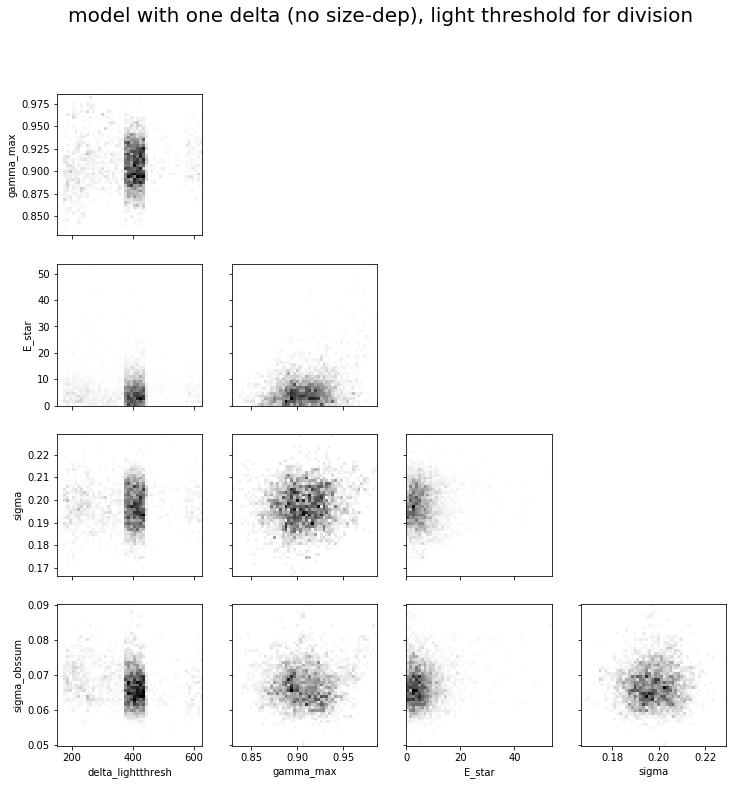

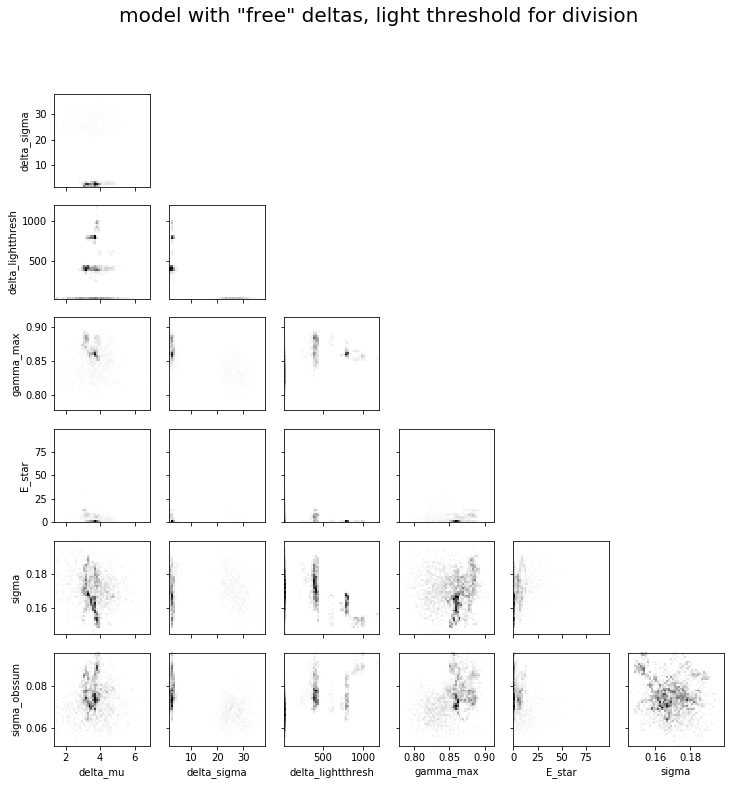

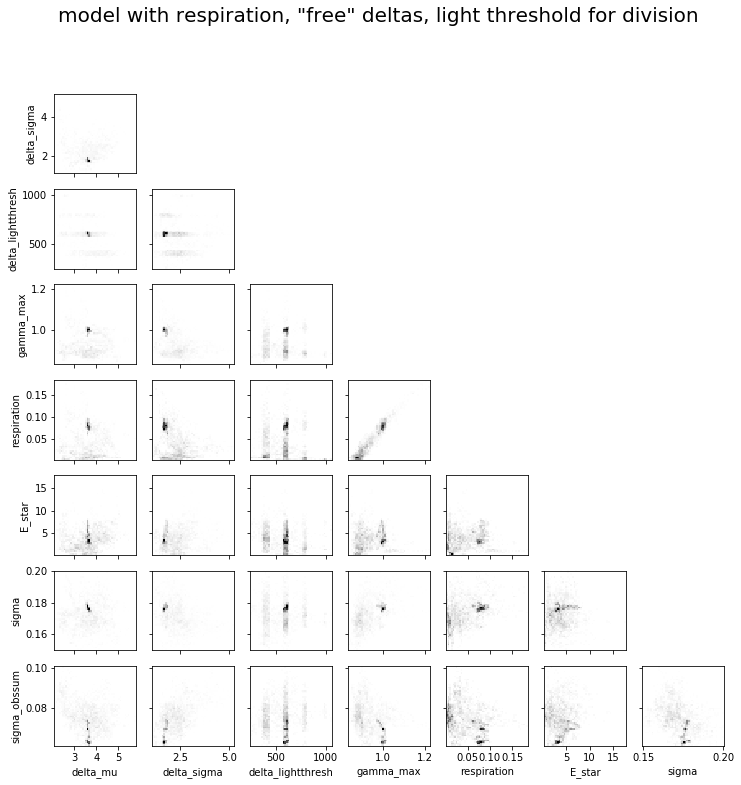

In [13]:
for name,mcmc in mcmcs.items():
    paramnames = [v for v in mcmc.flatnames if not v.startswith('mod_obspos') and not v.startswith('delta_max')]
    num_params = len(paramnames)

    fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
    fig.suptitle(desc[name], size=20)
    for ax in axs.flat:
        ax.set_visible(False)
    for irow in range(1,num_params):
        for icol in range(irow):
            ax = axs[irow-1,icol]
            ax.set_visible(True)
            xname = paramnames[icol]
            yname = paramnames[irow]
            ax.hist2d(mcmc[xname],mcmc[yname],bins=50,cmap=mpl.cm.gray_r)
            if icol == 0:
                ax.set_ylabel(yname)
            if irow == num_params-1:
                ax.set_xlabel(xname)

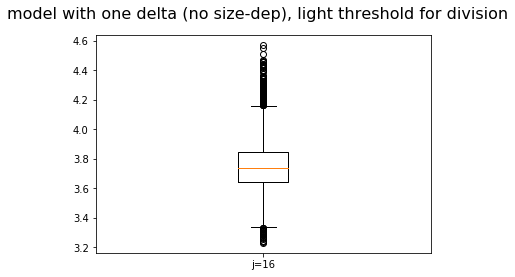

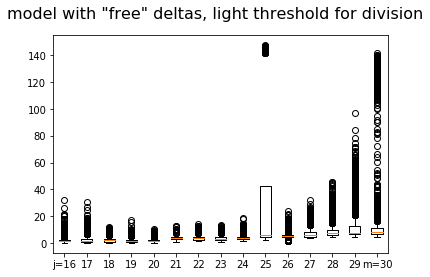

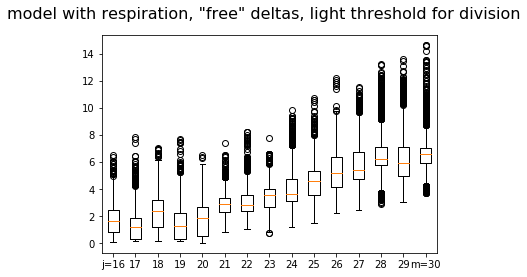

In [14]:
for name,mcmc in mcmcs.items():
    j = data_gridded['delta_v_inv'] + 1
    m = data_gridded['m']
    
    fig, ax = plt.subplots()
    fig.suptitle(desc[name], size=16)
    ax.boxplot(mcmc['delta_max'])
    xlabels = [str(x) for x in range(j,m+1)]
    xlabels[0] = 'j='+xlabels[0]
    xlabels[-1] = 'm='+xlabels[-1]
    ax.set_xticklabels(xlabels)
    None

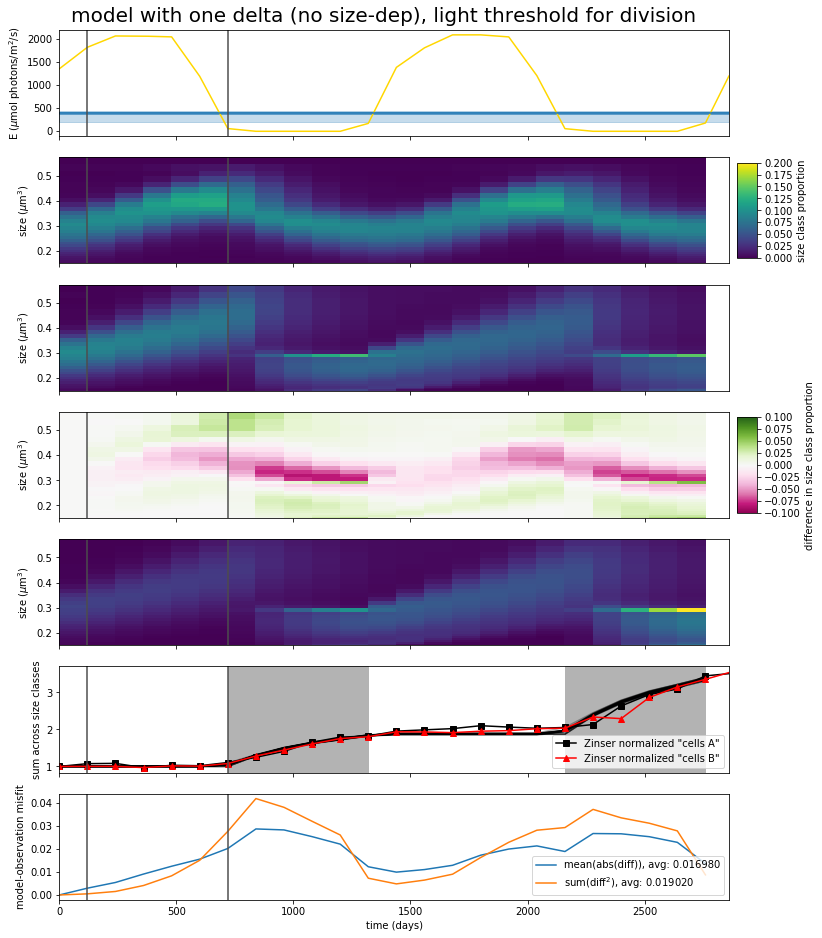

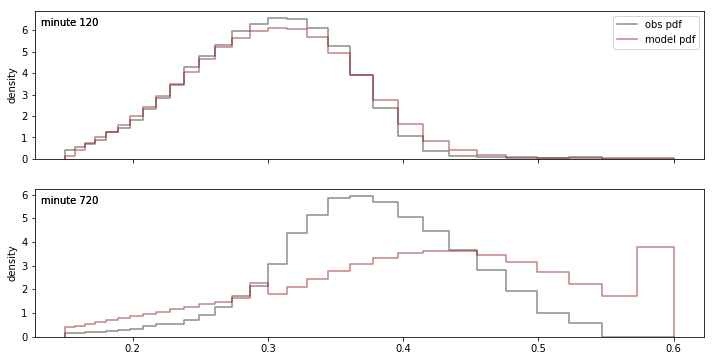

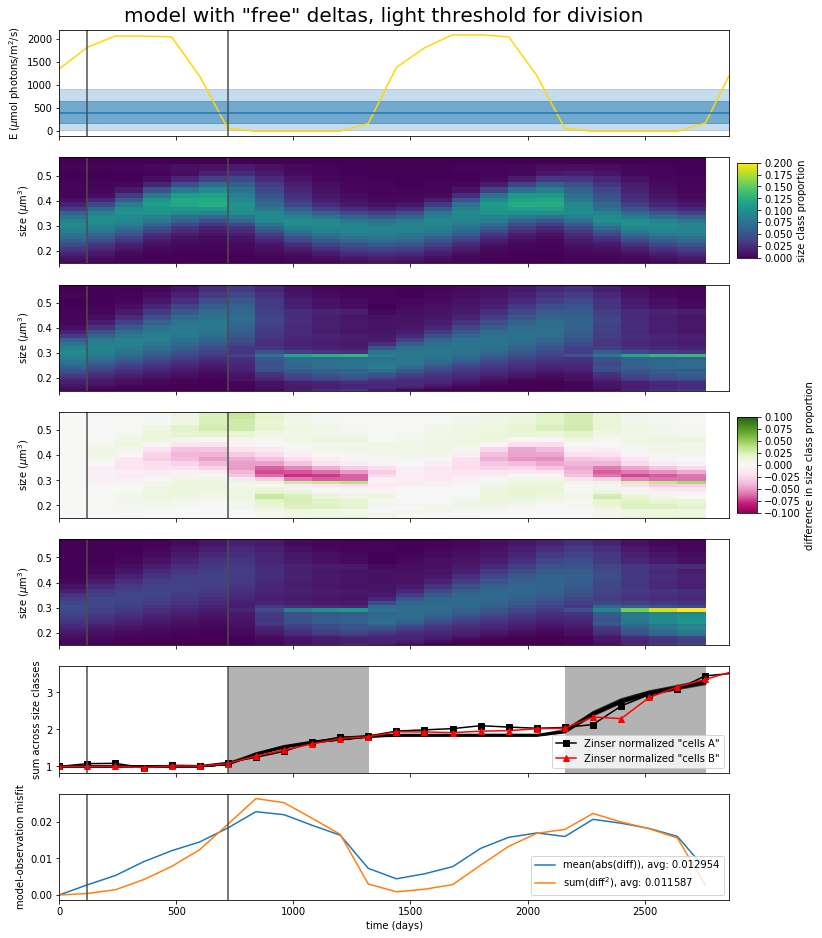

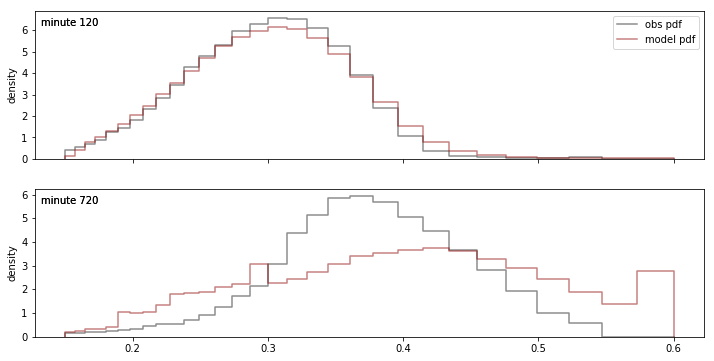

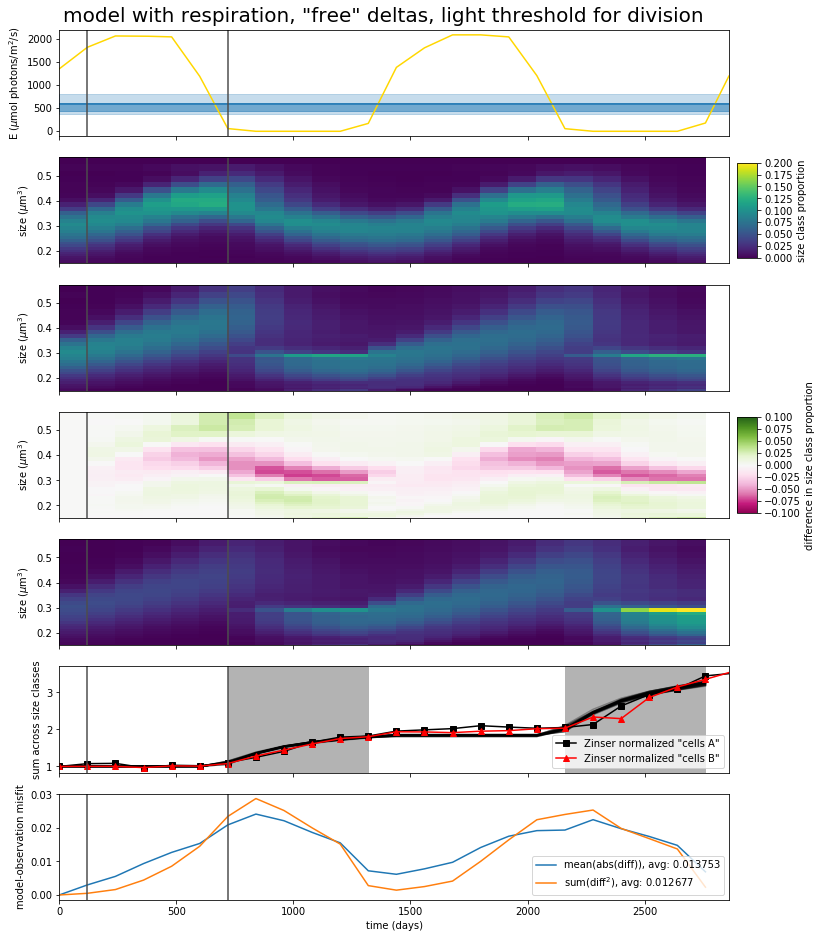

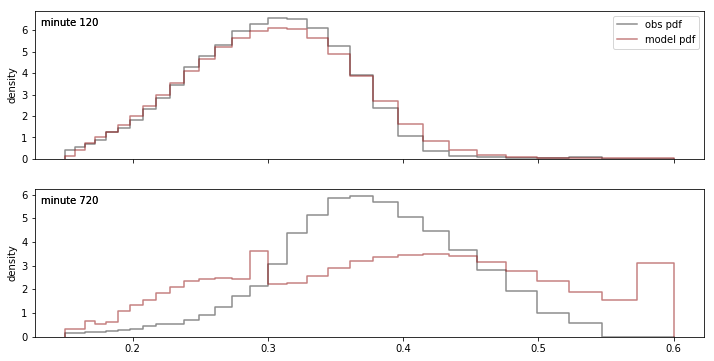

In [17]:
colors = {'model':'darkred', 'obs':'0.1'}

t = data['dt']*np.arange(data['nt'])
slice_indices = [1,6]
v_ext = data['v_min'] * 2**(np.arange(data['m']+1)*delta_v) 
v_width = v_ext[1:] - v_ext[:-1]

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for name,mcmc in mcmcs.items():
    res = {'model':np.mean(mcmc['mod_obspos'], axis=0), 'obs':data['obs']}
    res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
    diff = res_sum1-res['obs']

    fig,axs = plt.subplots(7,1,sharex=True,figsize=(12,16))
    fig.suptitle(desc[name], size=20, y=0.9)
    
    ax = axs[0]
    ax.plot(t, data['E'], color='gold')
    ax.set(xlim=(data['t_obs'][0],t[-1]), ylabel='E ($\mu$mol photons/m$^{2}$/s)')
    if 'delta_lightthresh' in mcmc.flatnames:
        qq = np.percentile(mcmc['delta_lightthresh'], (5,25,50,75,95))
        ax.axhspan(qq[0], qq[-1], color='C0', alpha=0.25)
        ax.axhspan(qq[1], qq[-2], color='C0', alpha=0.5)
        ax.axhline(qq[2], color='C0')

    ax = axs[1]
    pc = ax.pcolormesh(data['t_obs'],v,res['obs'],norm=norm)
    ax.set(ylabel='size ($\mu$m$^3$)')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

    ax = axs[2]
    ax.set(ylabel='size ($\mu$m$^3$)')
    pc = ax.pcolormesh(data['t_obs'],v,res_sum1,norm=norm)

    ax = axs[3]
    pc = ax.pcolormesh(data['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
    ax.set(ylabel='size ($\mu$m$^3$)')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

    ax = axs[4]
    ax.set(ylabel='size ($\mu$m$^3$)')
    pc = ax.pcolormesh(data['t_obs'],v,res['model'])

    ax = axs[5]
    ax.plot(data['t_obs'], np.sum(res['model'],axis=0))
    ax.plot(data['t_obs'], np.sum(mcmc['mod_obspos'][:30,...], axis=1).T, color='k', alpha=0.3)
    ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
    ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
    for iday in range(2):
        ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
    ax.legend()
    ax.set(ylabel='sum across size classes')

    ax = axs[6]
    prop = np.mean(np.abs(diff),axis=0)
    ax.plot(data['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
    prop = np.sum(diff**2,axis=0)
    ax.plot(data['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
    ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
    ax.legend()

    for ax in axs.flat:
        for i in slice_indices:
            ax.axvline(data['t_obs'][i], color='.3')

    # plot slices

    plotdata_y = np.zeros(2*(data['m']+1))

    fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
    for i,ax in zip(slice_indices,axs.flat):
        for name in ('obs','model'):
            color = colors[name]
            cdata = res[name][:,i]
            plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
            ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
            ax.text(0.01, 0.95, 'minute {}'.format(data['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
            ax.set_ylabel('density')
            ax.set_ylim(bottom=0.0)
    axs[0].legend()
    None

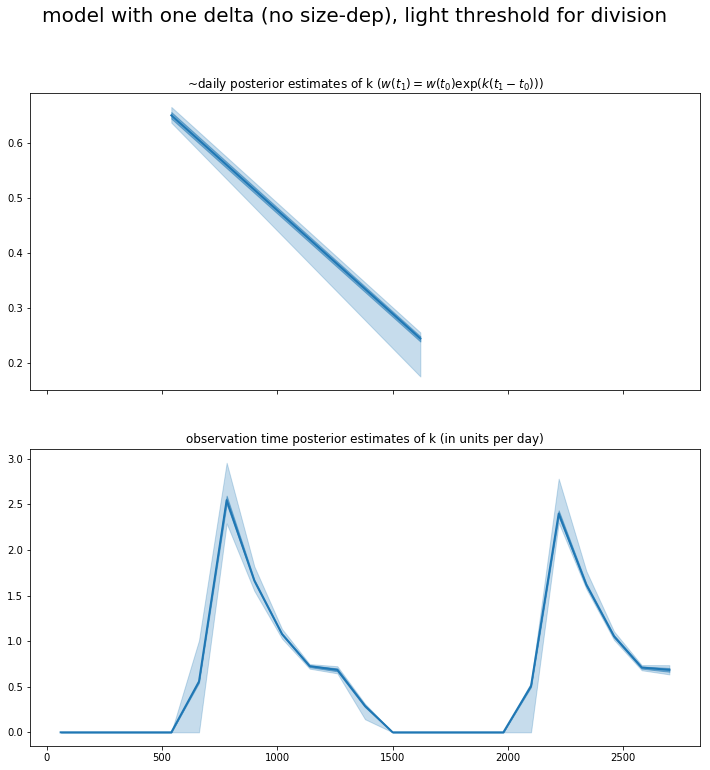

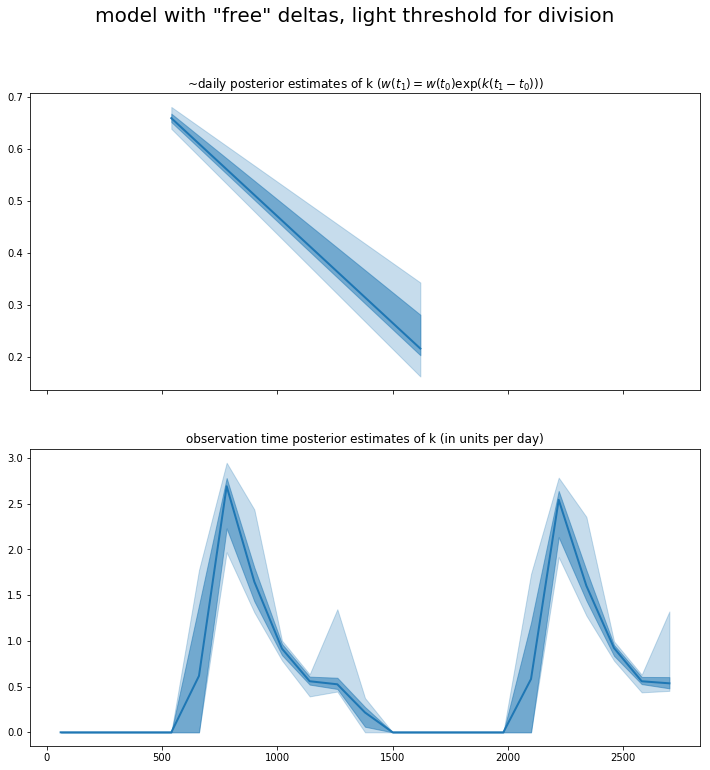

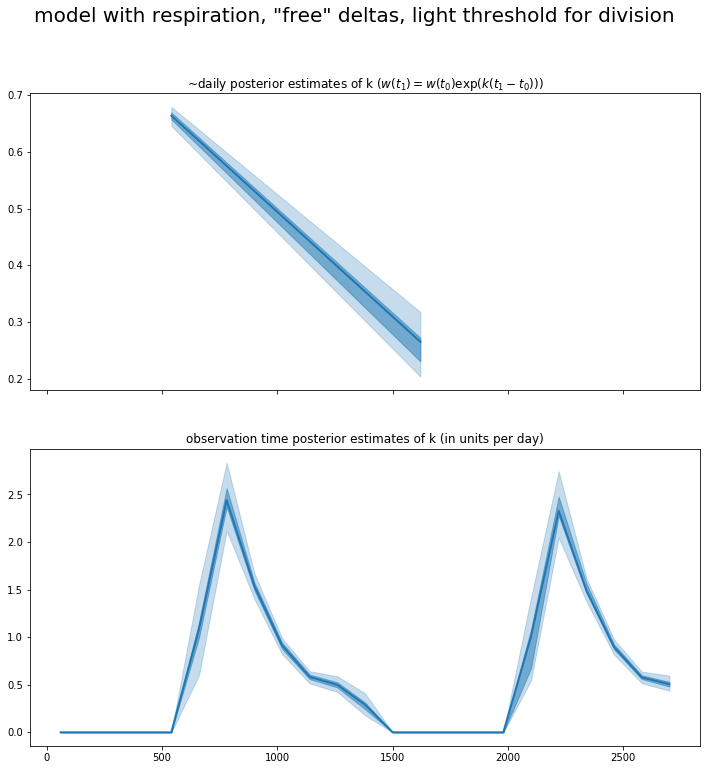

In [16]:
dt_obs = data['t_obs'][1]-data['t_obs'][0]

ndt = {'day':9, 'dt_obs':1}

for name,mcmc in mcmcs.items():
    sum_pop = np.sum(mcmc['mod_obspos'], axis=1)

    fig,axs = plt.subplots(nrows=2,sharex=True,figsize=(12,12))
    fig.suptitle(desc[name], size=20)
    for ax,key in zip(axs,ndt):
        t = data['t_obs'][::ndt[key]]
        tmp = sum_pop[:,::ndt[key]]
        tmp = tmp[:,1:] / tmp[:,:-1]
        k = np.log(tmp)/((t[1:]-t[:-1])/1440.0)

        q = np.percentile(k, q=(5,25,50,75,95), axis=0)

        t_mid = 0.5*(t[1:]+t[:-1])

        ax.fill_between(t_mid, q[0,:], q[-1,:], color='C0', alpha=0.25)
        ax.fill_between(t_mid, q[1,:], q[-2,:], color='C0', alpha=0.5)
        ax.plot(t_mid, q[2,:], color='C0', lw=2)
    axs[0].set_title('~daily posterior estimates of k ($w(t_1) = w(t_0)\exp(k (t_1-t_0))$)')
    axs[1].set_title('observation time posterior estimates of k (in units per day)')
    None

### create plot for export

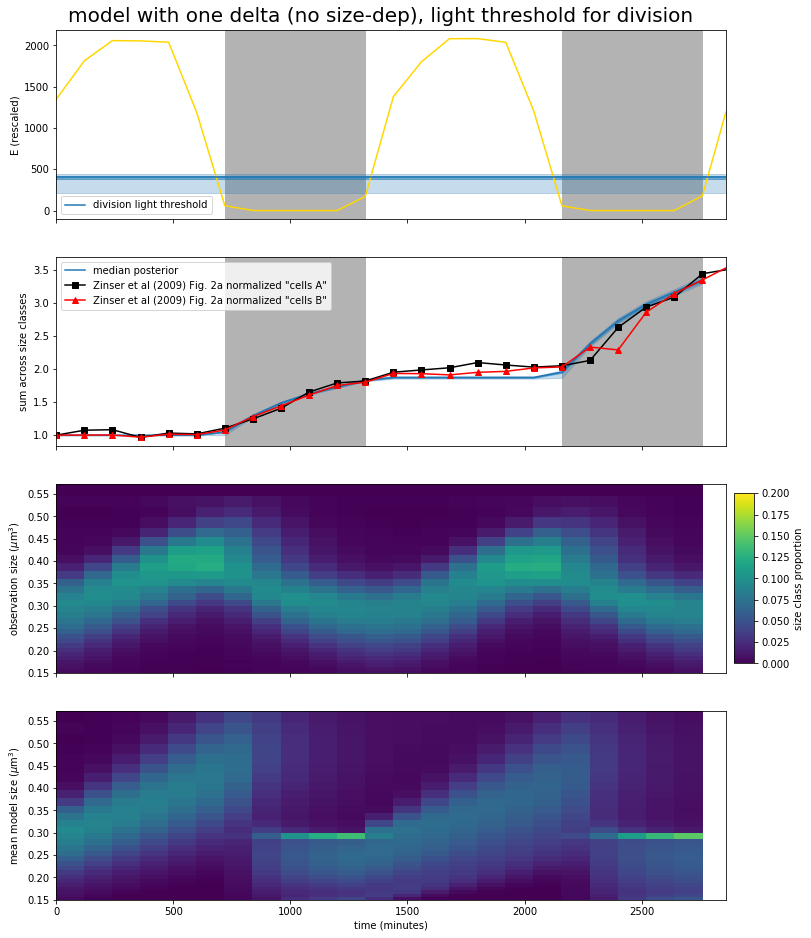

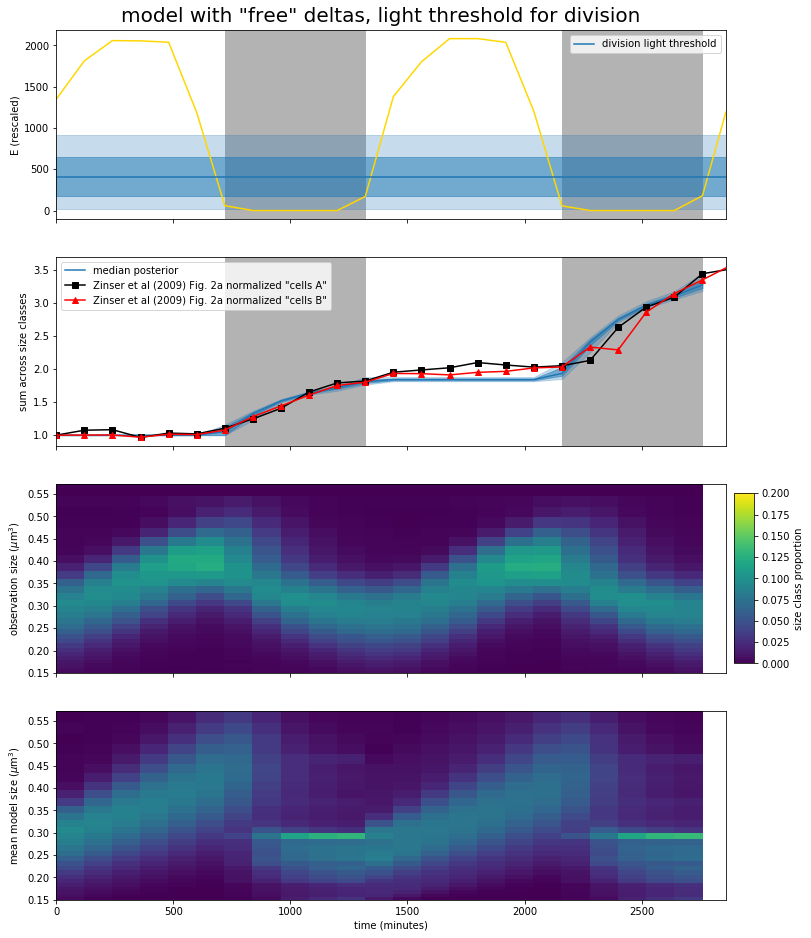

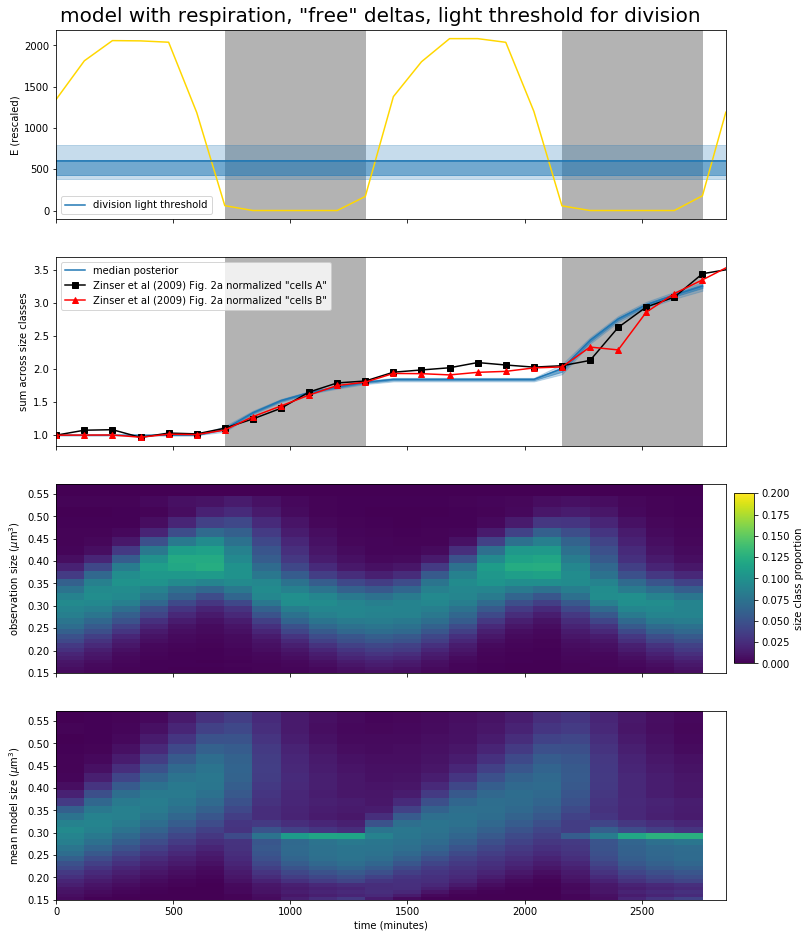

In [35]:
for name,mcmc in mcmcs.items():
    res = {'model':np.mean(mcmc['mod_obspos'], axis=0), 'obs':data['obs']}
    res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
    diff = res_sum1-res['obs']

    fig,axs = plt.subplots(4,1,sharex=True,figsize=(12,16))
    fig.suptitle(desc[name], size=20, y=0.9)
    
    ax = axs[0]
    ax.plot(t, data['E'], color='gold')
    ax.set(xlim=(data['t_obs'][0],t[-1]), ylabel='E (rescaled)')
    for iday in range(2):
        ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
    if 'delta_lightthresh' in mcmc.flatnames:
        qq = np.percentile(mcmc['delta_lightthresh'], (5,25,50,75,95))
        ax.axhspan(qq[0], qq[-1], color='C0', alpha=0.25)
        ax.axhspan(qq[1], qq[-2], color='C0', alpha=0.5)
        ax.axhline(qq[2], color='C0', label='division light threshold')
        ax.legend()

    ax = axs[1]
    qq = np.percentile(np.sum(mcmc['mod_obspos'],axis=1), (5,25,50,75,95), axis=0)
    
    ax.fill_between(data['t_obs'], qq[0,:], qq[-1,:], color='C0', alpha=0.25)
    ax.fill_between(data['t_obs'], qq[1,:], qq[-2,:], color='C0', alpha=0.5)
    ax.plot(data['t_obs'], qq[2,:], color='C0', label='median posterior')
    #ax.plot(data['t_obs'], np.sum(res['model'],axis=0))
    #ax.plot(data['t_obs'], np.sum(mcmc['mod_obspos'][:30,...], axis=1).T, color='k', alpha=0.3)
    ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser et al (2009) Fig. 2a normalized "cells A"')
    ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser et al (2009) Fig. 2a normalized "cells B"')
    for iday in range(2):
        ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
    ax.legend()
    ax.set(ylabel='sum across size classes')

    ax = axs[2]
    pc = ax.pcolormesh(data['t_obs'],v,res['obs'],norm=norm,rasterized=True)
    ax.set(ylabel='observation size ($\mu$m$^3$)')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

    ax = axs[3]
    ax.set(ylabel='mean model size ($\mu$m$^3$)', xlabel='time (minutes)')
    pc = ax.pcolormesh(data['t_obs'],v,res_sum1,norm=norm,rasterized=True)

    # export
    #fig.savefig('experimental_zinser-fitpopgrowth_m30_{}.pdf'.format(name), bbox_inches='tight')